# Lesson 11: Multimodal

This notebook demonstrates how to build multimodal AI systems that can process and understand both text and visual content using Google's Gemini models. You'll learn to work with images and PDFs in various formats, implement multimodal RAG systems for semantic search, and create AI agents capable of visual reasoning.

We will use the `google-genai` library to interact with Google's Gemini models.

**Learning Objectives:**

1. **Process multimodal content**: Learn to handle images and PDFs in different formats (bytes, base64, URLs) with Gemini models
2. **Implement object detection**: Use multimodal LLMs for visual analysis and structured output generation
3. **Build multimodal RAG systems**: Create embeddings for images and text to enable semantic search across visual content
4. **Develop multimodal AI agents**: Construct ReAct agents that can search through and reason about visual information

## 1. Setup

First, let's install the necessary Python libraries using pip.

!pip install -q google-genai pydantic python-dotenv

### Configure Gemini API Key

To use the Gemini API, you need an API key. 

1.  Get your key from [Google AI Studio](https://aistudio.google.com/app/apikey).
2.  Create a file named `.env` in the root of this project.
3.  Add the following line to the `.env` file, replacing `your_api_key_here` with your actual key:
    ```
    GOOGLE_API_KEY="your_api_key_here"
    ```
The code below will load this key from the `.env` file.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from lessons.utils import env

env.load(required_env_vars=["GOOGLE_API_KEY"])

Trying to load environment variables from `/Users/pauliusztin/Documents/01_projects/TAI/course-ai-agents/.env`
Environment variables loaded successfully.


### Import Key Packages

In [3]:
import base64
import io
from pathlib import Path
from typing import Literal

from google import genai
from google.genai import types
from IPython.display import Image as IPythonImage
from PIL import Image as PILImage

from lessons.utils import pretty_print

### Initialize the Gemini Client

In [4]:
client = genai.Client()

### Define Constants

We will use the `gemini-2.5-flash` model, which is fast, cost-effective, and supports advanced features like tool use.

In [5]:
MODEL_ID = "gemini-2.5-flash"

## 2. Applying multimodal LLMs to images and PDFs

There are three core ways we can process images and PDFs with multimodal models:
1. As raw bytes
2. As base64 encoded strings
3. As URLs

First, let's examine a test image:


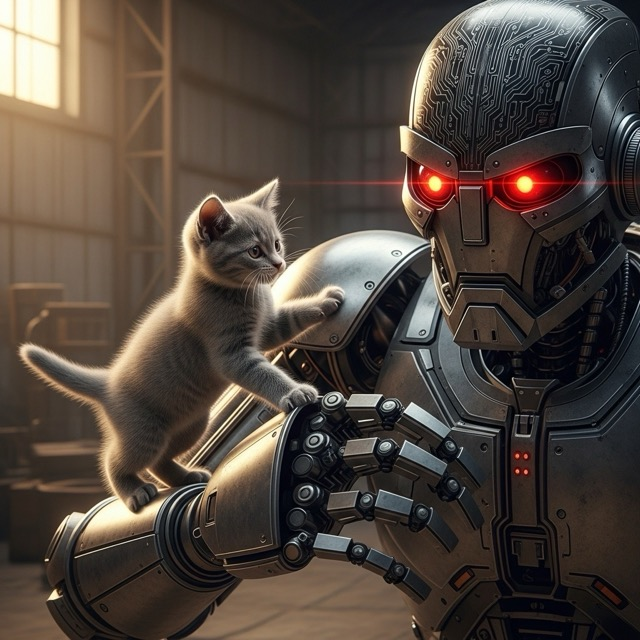

In [6]:
def display_image(image_path: Path) -> None:
    """
    Display an image from a file path in the notebook.

    Args:
        image_path: Path to the image file to display

    Returns:
        None
    """

    image = IPythonImage(filename=image_path, width=400)
    display(image)


display_image(Path("images") / "image_1.jpeg")

### 2.1 As raw bytes

In [7]:
def load_image_as_bytes(
    image_path: Path, format: Literal["WEBP", "JPEG", "PNG"] = "WEBP", max_width: int = 600, return_size: bool = False
) -> bytes | tuple[bytes, tuple[int, int]]:
    """
    Load an image from file path and convert it to bytes with optional resizing.

    Args:
        image_path: Path to the image file to load
        format: Output image format (WEBP, JPEG, or PNG). Defaults to "WEBP"
        max_width: Maximum width for resizing. If image width exceeds this, it will be resized proportionally. Defaults to 600
        return_size: If True, returns both bytes and image size tuple. Defaults to False

    Returns:
        bytes: Image data as bytes, or tuple of (bytes, (width, height)) if return_size is True
    """

    image = PILImage.open(image_path)
    if image.width > max_width:
        ratio = max_width / image.width
        new_size = (max_width, int(image.height * ratio))
        image = image.resize(new_size)

    byte_stream = io.BytesIO()
    image.save(byte_stream, format=format)

    if return_size:
        return byte_stream.getvalue(), image.size

    return byte_stream.getvalue()

In [8]:
image_bytes = load_image_as_bytes(image_path=Path("images") / "image_1.jpeg", format="WEBP")
pretty_print.wrapped([f"Bytes `{image_bytes[:30]}...`", f"Size: {len(image_bytes)} bytes"], title="Image as Bytes")

------------------------------------------ Image as Bytes ------------------------------------------
  Bytes `b'RIFF`\xad\x00\x00WEBPVP8 T\xad\x00\x00P\xec\x02\x9d\x01*X\x02X\x02'...`
----------------------------------------------------------------------------------------------------
  Size: 44392 bytes
----------------------------------------------------------------------------------------------------


In [9]:
response = client.models.generate_content(
    model=MODEL_ID,
    contents=[
        types.Part.from_bytes(
            data=image_bytes,
            mime_type="image/webp",
        ),
        "Tell me what is in this image in one paragraph.",
    ],
)
pretty_print.wrapped(response.text, title="Image 1 Caption")


----------------------------------------- Image 1 Caption -----------------------------------------
  The image prominently features a large, formidable-looking robot interacting with a small, grey tabby kitten within an industrial or workshop environment. The robot is crafted from dark, metallic armor with intricate circuitry patterns etched into its head, and its eyes glow with an intense red light. The curious kitten is playfully perched on the robot's extended left arm, with its front paws reaching up towards the robot's shoulder, seemingly engaging with the massive machine. The background is dimly lit, revealing metal structures and suggesting a sense of depth and scale, while soft light from an upper window illuminates the scene and highlights the textures of both the robot's metallic surface and the kitten's soft fur.
----------------------------------------------------------------------------------------------------


Using the same approach, we can easily pass multiple images simultaneously:

In [10]:
response = client.models.generate_content(
    model=MODEL_ID,
    contents=[
        types.Part.from_bytes(
            data=load_image_as_bytes(image_path=Path("images") / "image_1.jpeg", format="WEBP"),
            mime_type="image/webp",
        ),
        types.Part.from_bytes(
            data=load_image_as_bytes(image_path=Path("images") / "image_2.jpeg", format="WEBP"),
            mime_type="image/webp",
        ),
        "What's the difference between these two images? Describe it in one paragraph.",
    ],
)
pretty_print.wrapped(response.text, title="Differences between images")


------------------------------------ Differences between images ------------------------------------
  The primary difference between the two images lies in the nature of the interaction and the mood portrayed. The first image depicts a gentle and curious encounter, with a small, grey kitten playfully standing on the arm of a large, grey robot in what appears to be a clean industrial setting, suggesting an unusual companionship. In stark contrast, the second image showcases a tense and aggressive confrontation between a sleek, black robot and a large white dog, both adopting defensive or attacking stances in a dirty, trash-filled urban alleyway, conveying a sense of conflict and hostility.
----------------------------------------------------------------------------------------------------


### 2.2 As base64 encoded strings


In [11]:
from typing import cast


def load_image_as_base64(
    image_path: Path, format: Literal["WEBP", "JPEG", "PNG"] = "WEBP", max_width: int = 600, return_size: bool = False
) -> str:
    """
    Load an image and convert it to base64 encoded string.

    Args:
        image_path: Path to the image file to load
        format: Output image format (WEBP, JPEG, or PNG). Defaults to "WEBP"
        max_width: Maximum width for resizing. If image width exceeds this, it will be resized proportionally. Defaults to 600
        return_size: Parameter passed to load_image_as_bytes function. Defaults to False

    Returns:
        str: Base64 encoded string representation of the image
    """

    image_bytes = load_image_as_bytes(image_path=image_path, format=format, max_width=max_width, return_size=False)

    return base64.b64encode(cast(bytes, image_bytes)).decode("utf-8")

In [12]:
image_base64 = load_image_as_base64(image_path=Path("images") / "image_1.jpeg", format="WEBP")
pretty_print.wrapped(
    [f"Base64: {image_base64[:100]}...`", f"Size: {len(image_base64)} characters"], title="Image as Base64"
)

----------------------------------------- Image as Base64 -----------------------------------------
  Base64: UklGRmCtAABXRUJQVlA4IFStAABQ7AKdASpYAlgCPm0ylEekIqInJnQ7gOANiWdtk7FnEo2gDknjPixW9SNSb5P7IbBNhLn87Vtp...`
----------------------------------------------------------------------------------------------------
  Size: 59192 characters
----------------------------------------------------------------------------------------------------


On average base64 format is 33% larger than raw bytes. As we can see in this use case as well:

In [13]:
print(f"Image as Base64 is {(len(image_base64) - len(image_bytes)) / len(image_bytes) * 100:.2f}% larger than as bytes")

Image as Base64 is 33.34% larger than as bytes


In [14]:
response = client.models.generate_content(
    model=MODEL_ID,
    contents=[
        types.Part.from_bytes(data=image_base64, mime_type="image/webp"),
        "Tell me what is in this image in one paragraph.",
    ],
)
response.text


"The image presents a striking scene featuring a large, formidable-looking robot alongside a small, fluffy grey tabby kitten. The robot, dominating the right side of the frame, is depicted in dark metallic armor with intricate circuitry-like patterns on its head and piercing red glowing eyes, conveying a sense of immense power and advanced technology. Contrasting sharply with its imposing presence, the tiny kitten is seen playfully perched on the robot's heavy metallic arm and shoulder, its paws gently exploring or batting at the machinery. The setting appears to be a dimly lit, industrial-style environment with blurred structures and machinery in the background, further emphasizing the unusual and charming interaction between the advanced automaton and the delicate animal."

### 2.3 As URLs

At the time of writing this notebook, Gemini works well primarily with GCP Cloud Storage links, which are excellent for production use cases but complicate our simple demonstration.

The code would not change much and would look like this:
```python
response = client.models.generate_content(
    model=MODEL_ID,
    contents=[
        types.Part.from_uri(uri="gs://gemini-images/image_1.jpeg", mime_type="image/webp"),
        "Tell me what is in this image in one paragraph.",
    ],
)
```

### 2.4 Object detection with LLMs

As a more exciting example, let's do object detection with multimodal LLMs.

First, let's define the output Pydantic models:

In [15]:
from pydantic import BaseModel, Field


class BoundingBox(BaseModel):
    ymin: float
    xmin: float
    ymax: float
    xmax: float
    label: str = Field(default="The object found within the bounding box.")


class Detections(BaseModel):
    bounding_boxes: list[BoundingBox]

Then the prompt and image:

In [16]:
prompt = """
Detect all of the prominent items in the image. The box_2d should be [ymin, xmin, ymax, xmax] normalized to 0-1000.
"""

image_bytes, image_size = load_image_as_bytes(
    image_path=Path("images") / "image_1.jpeg", format="WEBP", return_size=True
)

Now, let's call the LLM:

In [17]:
config = types.GenerateContentConfig(
    response_mime_type="application/json",
    response_schema=Detections,
)

response = client.models.generate_content(
    model=MODEL_ID,
    contents=[
        types.Part.from_bytes(
            data=image_bytes,
            mime_type="image/webp",
        ),
        prompt,
    ],
    config=config,
)

width, height = image_size
print("Image size: ", width, height)
detections = cast(Detections, response.parsed)

for bounding_box in detections.bounding_boxes:
    bounding_box.ymin = int(bounding_box.ymin / 1000 * height)
    bounding_box.xmin = int(bounding_box.xmin / 1000 * width)
    bounding_box.ymax = int(bounding_box.ymax / 1000 * height)
    bounding_box.xmax = int(bounding_box.xmax / 1000 * width)
    print(bounding_box)

Image size:  600 600
ymin=53 xmin=216 ymax=555 xmax=600 label='robot'
ymin=161 xmin=18 ymax=445 xmax=315 label='kitten'


Let's also visualize the bounding boxes: 

In [18]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np


def visualize_detections(detections: Detections, image_path: Path) -> None:
    """
    Visualize detected bounding boxes on an image with red rectangles and labels.

    Args:
        detections: Detections object containing bounding boxes with pixel coordinates
        image_path: Path to the image file to visualize

    Returns:
        None: Displays the image with bounding boxes in the notebook
    """

    image = PILImage.open(image_path)
    image_array = np.array(image)

    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    ax.imshow(image_array)

    for bbox in detections.bounding_boxes:
        # Calculate box dimensions (matplotlib uses bottom-left corner + width/height)
        width = bbox.xmax - bbox.xmin
        height = bbox.ymax - bbox.ymin

        # Create rectangle patch (x, y is bottom-left corner)
        rect = patches.Rectangle((bbox.xmin, bbox.ymin), width, height, linewidth=3, edgecolor="red", facecolor="none")

        # Add rectangle to the plot
        ax.add_patch(rect)

        # Add label text (positioned at bottom-left of bounding box)
        ax.text(
            bbox.xmin,
            bbox.ymax + 5,  # Slightly below the box
            bbox.label,
            fontsize=12,
            color="red",
            fontweight="bold",
            bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8),
        )

    # Remove axis ticks and labels for cleaner display
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f"Object Detection Results: {image_path.name}", fontsize=14, fontweight="bold")

    plt.tight_layout()
    plt.show()

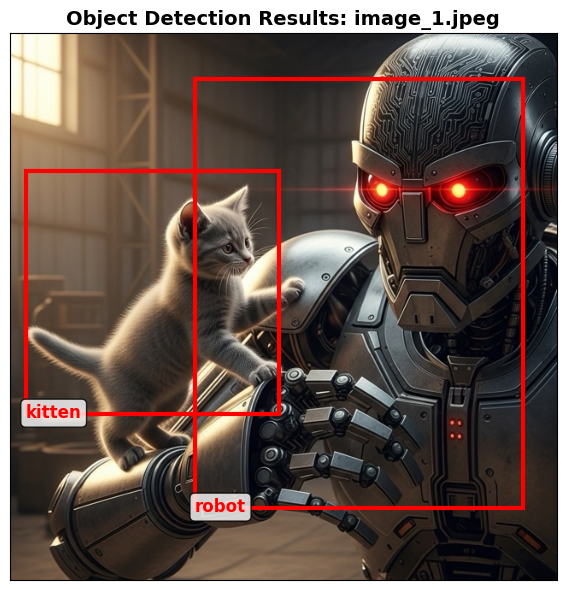

In [19]:
visualize_detections(detections, Path("images") / "image_1.jpeg")

### 2.5 Working with PDFs

We can treat PDFs similarly to images. Therefore, we can pass PDFs as bytes:


In [20]:
pdf_bytes = (Path("pdfs") / "decoding_ml_article.pdf").read_bytes()
pretty_print.wrapped(f"Bytes: {pdf_bytes[:40]}...", title="PDF bytes")

-------------------------------------------- PDF bytes --------------------------------------------
  Bytes: b'%PDF-1.4\n%\xd3\xeb\xe9\xe1\n1 0 obj\n<</Title (5 AI En'...
----------------------------------------------------------------------------------------------------


In [21]:
response = client.models.generate_content(
    model=MODEL_ID,
    contents=[
        types.Part.from_bytes(data=pdf_bytes, mime_type="application/pdf"),
        "What is this document about? Provide a brief summary of the main topics.",
    ],
)
pretty_print.wrapped(response.text, title="PDF Summary (as bytes)")

-------------------------------------- PDF Summary (as bytes) --------------------------------------
  This document is an article by Paul Iusztin titled "5 Books to Ship AI Products in 2025," which provides his top five recommended books (plus a bonus) for individuals looking to get into AI Engineering, particularly focusing on Large Language Models (LLMs) and agentic systems.

The article summarizes each book's key contributions:

1.  **Designing Machine Learning Systems** by Chip Huyen: Covers end-to-end ML systems, MLOps, and architecture.
2.  **Prompt Engineering for LLMs** by John Berryman and Albert Ziegler: Focuses on engineering prompts for flexibility and scalability.
3.  **AI Engineering** by Chip Huyen: Discusses AI vs. ML Engineering, RAG, agentic systems, and LLMOps.
4.  **Building LLMs for Production** by Louis-François Bouchard and Louie Peters: A hands-on guide to implementing LLM applications, including RAG and fine-tuning.
5.  **LLMs in Production** by Christopher Br

Alternatively, as base64 encoded strings:

In [22]:
def load_pdf_as_base64(pdf_path: Path) -> str:
    """
    Load a PDF file and convert it to base64 encoded string.

    Args:
        pdf_path: Path to the PDF file to load

    Returns:
        str: Base64 encoded string representation of the PDF
    """

    with open(pdf_path, "rb") as f:
        return base64.b64encode(f.read()).decode("utf-8")

In [23]:
pdf_base64 = load_pdf_as_base64(pdf_path=Path("pdfs") / "decoding_ml_article.pdf")
pretty_print.wrapped(f"Base64: {pdf_base64[:40]}...", title="PDF as Base64")

------------------------------------------ PDF as Base64 ------------------------------------------
  Base64: JVBERi0xLjQKJdPr6eEKMSAwIG9iago8PC9UaXRs...
----------------------------------------------------------------------------------------------------


In [24]:
response = client.models.generate_content(
    model=MODEL_ID,
    contents=[
        "What is this document about? Provide a brief summary of the main topics.",
        types.Part.from_bytes(data=pdf_base64, mime_type="application/pdf"),
    ],
)

pretty_print.wrapped(response.text, title="PDF Summary (as base64)")


------------------------------------- PDF Summary (as base64) -------------------------------------
  This document is an article titled "5 Books to Ship AI Products in 2025," authored by Paul Iusztin.

**Main Topics:**

The article provides a curated list of five (plus a bonus) recommended books for individuals interested in **AI Engineering**, specifically focusing on **Large Language Models (LLMs)** and **agentic systems**. The books cover a progression from foundational concepts to more niche and hands-on aspects of building and deploying AI products.

The main topics addressed by these recommendations include:

1.  **Designing Machine Learning Systems:** Fundamental principles of building end-to-end ML systems, including architecture, model/data management, and MLOps.
2.  **Prompt Engineering for LLMs:** Techniques for effectively engineering prompts to manipulate and optimize LLM behavior for specific applications.
3.  **AI Engineering Concepts:** A broader overview of AI enginee

## 3. Implementing multimodal RAG for images and text

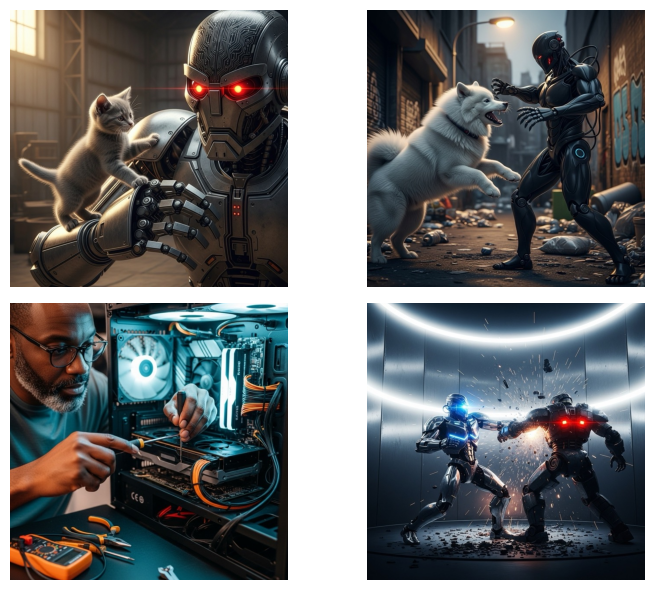

In [25]:
def display_image_grid(image_paths: list[Path], rows: int = 2, cols: int = 2, figsize: tuple = (8, 6)) -> None:
    """
    Display a grid of images.

    Args:
        image_paths: List of paths to images to display
        rows: Number of rows in the grid
        cols: Number of columns in the grid
        figsize: Figure size as (width, height)
    """

    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    axes = axes.ravel()

    for idx, img_path in enumerate(image_paths[: rows * cols]):
        img = PILImage.open(img_path)
        axes[idx].imshow(img)
        axes[idx].axis("off")

    plt.tight_layout()
    plt.show()


display_image_grid(
    image_paths=[
        Path("images") / "image_1.jpeg",
        Path("images") / "image_2.jpeg",
        Path("images") / "image_3.jpeg",
        Path("images") / "image_4.jpeg",
    ],
    rows=2,
    cols=2,
)

In [26]:
from io import BytesIO
from typing import Any

import numpy as np


def generate_image_description(image_bytes: bytes) -> str:
    """
    Generate a detailed description of an image using Gemini Vision model.

    Args:
        image_bytes: Image data as bytes

    Returns:
        str: Generated description of the image
    """

    try:
        # Convert bytes back to PIL Image for vision model
        img = PILImage.open(BytesIO(image_bytes))

        # Use Gemini Vision model to describe the image
        prompt = """
        Describe this image in detail for semantic search purposes. 
        Include objects, scenery, colors, composition, text, and any other visual elements that would help someone find 
        this image through text queries.
        """

        response = client.models.generate_content(
            model=MODEL_ID,
            contents=[prompt, img],
        )

        if response and response.text:
            description = response.text.strip()

            return description
        else:
            print("❌ No description generated from vision model")

            return ""

    except Exception as e:
        print(f"❌ Failed to generate image description: {e}")

        return ""


In [27]:
def embed_text_with_gemini(content: str) -> np.ndarray | None:
    """
    Embed text content using Gemini's text embedding model.

    Args:
        content: Text string to embed

    Returns:
        np.ndarray | None: Embedding vector as numpy array or None if failed
    """

    try:
        result = client.models.embed_content(
            model="gemini-embedding-001",  # Gemini's text embedding model
            contents=[content],
        )
        if not result or not result.embeddings:
            print("❌ No embedding data found in response")
            return None

        return np.array(result.embeddings[0].values)

    except Exception as e:
        print(f"❌ Failed to embed text: {e}")
        return None

In [28]:
embed_text_with_gemini("This is a test")

array([-0.02252334, -0.00076438,  0.00240217, ..., -0.00574729,
       -0.00052345, -0.00213343], shape=(3072,))

In [29]:
from typing import cast


def create_multimodal_embeddings(image_paths: list[Path]) -> list[dict]:
    """
    Create embeddings for both images and text using proper Gemini approach.

    This function processes a list of image paths, generates descriptions for each image
    using Gemini Vision model, and creates embeddings for those descriptions.

    Args:
        image_paths: List of Path objects pointing to image files to process

    Returns:
        list[dict]: List of dictionaries containing image data, descriptions, and embeddings.
                   Each dict contains keys: 'content', 'type', 'filename', 'description', 'embedding'
    """

    vector_index = []
    for image_path in image_paths:
        image_bytes = cast(bytes, load_image_as_bytes(image_path, format="WEBP", return_size=False))

        image_description = generate_image_description(image_bytes)
        pretty_print.wrapped(f"`{image_description[:500]}...`", title="Generated image description:")

        # IMPORTANT NOTE: When working with multimodal embedding models, we can directly embed the
        # `image_bytes` instead of generating and embedding the description. Otherwise, everything
        # else remains the same within the whole RAG system.
        image_embedding = embed_text_with_gemini(image_description)

        vector_index.append(
            {
                "content": image_bytes,
                "type": "image",
                "filename": image_path,
                "description": image_description,
                "embedding": image_embedding,
            }
        )

    return vector_index

In [30]:
image_paths = list(Path("images").glob("*.jpeg"))
vector_index = create_multimodal_embeddings(image_paths)

if len(vector_index) == 0:
    pretty_print.wrapped("No embeddings were created successfully", title="❌")
else:
    pretty_print.wrapped(f"Successfully created {len(vector_index)} embeddings", title="✅")

----------------------------------- Generated image description: -----------------------------------
  `This image depicts a striking juxtaposition of artificial intelligence and natural life, specifically a futuristic robot and an adorable kitten, in what appears to be an industrial or workshop setting.

**Objects:**
*   **Robot:** The dominant figure on the right is a large, imposing humanoid robot or android, possibly a combat or industrial model.
    *   **Head:** Its head features a highly detailed, intricate pattern resembling a circuit board or electronic pathways etched into its dark metal...`
----------------------------------------------------------------------------------------------------
----------------------------------- Generated image description: -----------------------------------
  `This image depicts a dynamic and dramatic confrontation between a large, fluffy white dog and a sleek, black humanoid robot in a gritty urban alleyway.

**Objects:**
*   **White Dog:** D

In [31]:
from sklearn.metrics.pairwise import cosine_similarity


def search_multimodal(query_text: str, vector_index: list[dict], top_k: int = 3) -> list[Any]:
    """
    Search for most similar documents to query using direct Gemini client.

    This function embeds the query text and compares it against pre-computed embeddings
    of document descriptions to find the most semantically similar matches.

    Args:
        query_text: Text query to search for
        docs: List of document dictionaries containing embeddings and metadata
        top_k: Number of top results to return. Defaults to 3

    Returns:
        list[Any]: List of document dictionaries with similarity scores, sorted by relevance
    """

    print(f"\n🔍 Embedding query: '{query_text}'")

    query_embedding = embed_text_with_gemini(query_text)

    if query_embedding is None:
        print("❌ Failed to embed query")
        return []
    else:
        print("✅ Query embedded successfully")

    # Calculate similarities using our custom function
    embeddings = [doc["embedding"] for doc in vector_index]
    similarities = cosine_similarity([query_embedding], embeddings).flatten()

    # Get top results
    top_indices = np.argsort(similarities)[::-1][:top_k]  # type: ignore

    results = []
    for idx in top_indices.tolist():
        results.append({**vector_index[idx], "similarity": similarities[idx]})

    return results


🔍 Embedding query: 'two robots fighting'
✅ Query embedded successfully
----------------------------- Results for query = two robots fighting -----------------------------
  Similarity 0.767
----------------------------------------------------------------------------------------------------
  Filename images/image_4.jpeg
----------------------------------------------------------------------------------------------------
  Description `This image depicts a high-octane, futuristic combat scene between two highly advanced humanoid robots or mechs within what appears to be a high-tech arena or combat chamber.

**Objects:**
*   **Two Robots/Mechs:** The central focus.
    *   **Left Robot:** Features a sleek, metallic silver and dark grey body with prominent electric blue glowing accents. These accents appear on its helmet (possibly as eyes or a visor), chest, and along its arm joints. It has a more agile, streamlined design, resembling a humanoid android. It is in the process of delivering

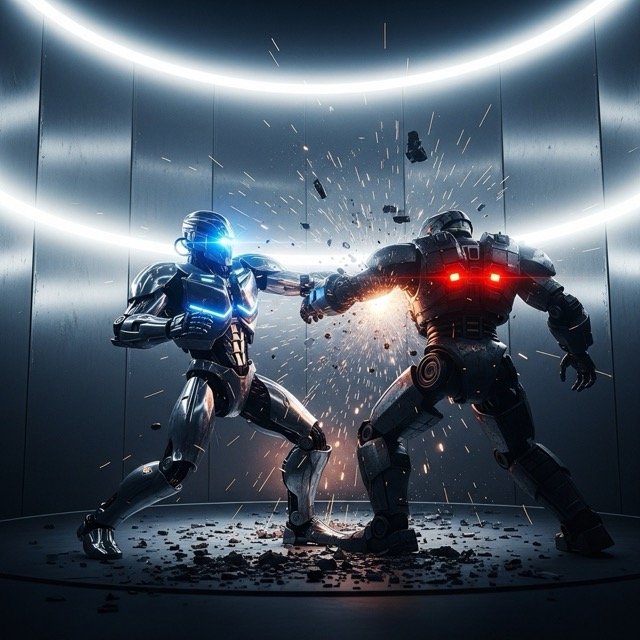

In [32]:
query = "two robots fighting"
results = search_multimodal(query, vector_index, top_k=1)

if not results:
    pretty_print.wrapped("❌ No results found", title="❌")
else:
    result = results[0]

    pretty_print.wrapped(
        [
            f"Similarity {result['similarity']:.3f}",
            f"Filename {result['filename']}",
            f"Description `{result['description'][:1000]}...`",
        ],
        title=f"Results for query = {query}",
    )
    display_image(Path(result["filename"]))


🔍 Embedding query: 'a kitten with a robot'
✅ Query embedded successfully
---------------------------- Results for query = a kitten with a robot ----------------------------
  Similarity 0.820
----------------------------------------------------------------------------------------------------
  Filename images/image_1.jpeg
----------------------------------------------------------------------------------------------------
  Description `This image depicts a striking juxtaposition of artificial intelligence and natural life, specifically a futuristic robot and an adorable kitten, in what appears to be an industrial or workshop setting.

**Objects:**
*   **Robot:** The dominant figure on the right is a large, imposing humanoid robot or android, possibly a combat or industrial model.
    *   **Head:** Its head features a highly detailed, intricate pattern resembling a circuit board or electronic pathways etched into its dark metallic surface, akin to microchips or a printed circuit board 

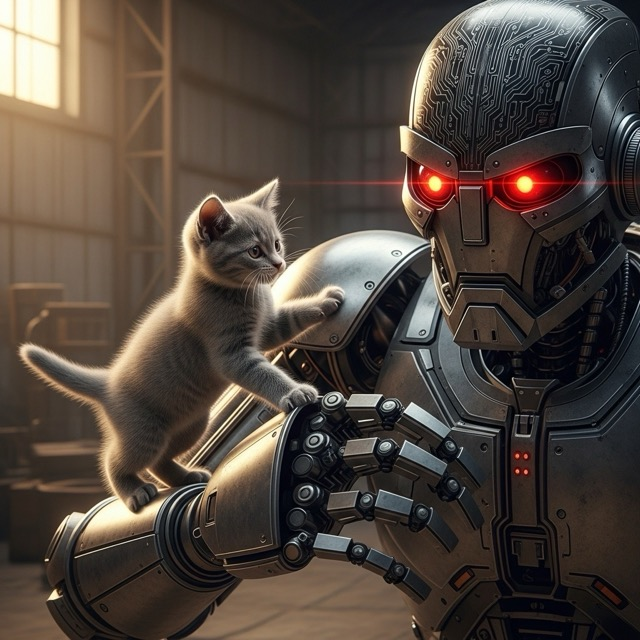

In [33]:
query = "a kitten with a robot"
results = search_multimodal(query, vector_index, top_k=1)

if not results:
    pretty_print.wrapped("❌ No results found", title="❌")
else:
    result = results[0]

    pretty_print.wrapped(
        [
            f"Similarity {result['similarity']:.3f}",
            f"Filename {result['filename']}",
            f"Description `{result['description'][:1000]}...`",
        ],
        title=f"Results for query = {query}",
    )
    display_image(Path(result["filename"]))

## 4. Building multimodal AI agents

In [34]:
from langchain_core.tools import tool
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.prebuilt import create_react_agent


@tool
def multimodal_search_tool(query: str) -> dict[str, Any]:
    """
    Search through a collection of images and their text descriptions to find relevant content.

    This tool searches through a pre-indexed collection of image-text pairs using the query
    and returns the most relevant match. The search uses multimodal embeddings to find
    semantic matches between the query and the content.

    Args:
        query: Text query describing what to search for (e.g., "cat", "kitten with robot")

    Returns:
        A formatted string containing the search result with description and similarity score
    """

    pretty_print.wrapped(query, title="🔍 Tool executing search for:")

    results = search_multimodal(query, vector_index, top_k=1)

    if not results:
        return {"role": "tool_result", "content": "No relevant content found for your query."}
    else:
        pretty_print.wrapped(str(results[0]["filename"]), title="🔍 Found results:")
    result = results[0]

    content = [
        {
            "type": "text",
            "text": f"Image description: {result['description']}",
        },
        types.Part.from_bytes(
            data=result["content"],
            mime_type="image/jpeg",
        ),
    ]

    return {
        "role": "tool_result",
        "content": content,
    }

In [35]:
def build_react_agent() -> Any:
    """
    Build a ReAct agent with multimodal search capabilities.

    This function creates a LangGraph ReAct agent that can search through images
    and text using the multimodal_search_tool. The agent uses Gemini 2.5 Pro
    for reasoning and tool execution.

    Returns:
        Any: A LangGraph ReAct agent instance configured with multimodal search tools
    """

    tools = [multimodal_search_tool]

    system_prompt = """You are a helpful AI assistant that can search through images and text to answer questions.
    
    When asked about visual content like animals, objects, or scenes:
    1. Use the multimodal_search_tool to find relevant images and descriptions
    2. Carefully analyze the image or image descriptions from the search results
    3. Look for specific details like colors, features, objects, or characteristics
    4. Provide a clear, direct answer based on the search results
    5. If you can't find the specific information requested, be honest about limitations
    
    Pay special attention to:
    - Colors and visual characteristics
    - Animal features and breeds
    - Objects and their properties
    - Scene descriptions and context
    
    Always search first using your tools before attempting to answer questions about specific images or visual content.
    """

    agent = create_react_agent(
        model=ChatGoogleGenerativeAI(model="gemini-2.5-pro", temperature=0.1),
        tools=tools,
        prompt=system_prompt,
    )

    return agent


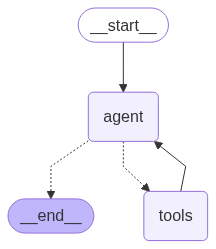

In [38]:
react_agent = build_react_agent()
react_agent

In [37]:
try:
    test_question = "what color is my kitten?"
    pretty_print.wrapped(test_question, title="🧪 Asking question:")

    response = react_agent.invoke(input={"messages": test_question})
    messages = response.get("messages", [])
    if messages:
        final_message = messages[-1].content
    else:
        final_message = "No response from the agent"
    pretty_print.wrapped(final_message, title="🤖 Agent response")
except Exception as e:
    print(f"❌ Error in ReAct agent: {e}")

---------------------------------------- 🧪 Asking question: ----------------------------------------
  what color is my kitten?
----------------------------------------------------------------------------------------------------
----------------------------------- 🔍 Tool executing search for: -----------------------------------
  my kitten
----------------------------------------------------------------------------------------------------

🔍 Embedding query: 'my kitten'
✅ Query embedded successfully
----------------------------------------- 🔍 Found results: -----------------------------------------
  images/image_1.jpeg
----------------------------------------------------------------------------------------------------
----------------------------------------- 🤖 Agent response -----------------------------------------
  Your kitten is a grey tabby.
----------------------------------------------------------------------------------------------------
